# Import Modules

In [141]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct

# Implementation

Quantization Matrix

In [142]:
quantization = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
])

quantization_B = np.array([
    [8, 6, 5, 8, 12, 20, 26, 31],
    [6, 6, 7, 10, 13, 29, 30, 28],
    [7, 7, 8, 12, 20, 29, 35, 28],
    [7, 9, 11, 15, 26, 44, 40, 31],
    [9, 11, 19, 28, 34, 55, 52, 39],
    [12, 18, 28, 32, 41, 52, 57, 46],
    [25, 32, 39, 44, 52, 61, 60, 51],
    [36, 46, 48, 49, 56, 50, 52, 50],
])


Predict Functions

In [143]:

'''
predict function 1
Description:
    Calculate the f(x, y) = f(-x, y) prediction
Input: x and y coordinates and the matrix of the coordinates
Output: one prediction
'''
def predict_function_1(x, y, matrix):
    M, N = matrix.shape

    error = x >= M or y >= N
    if error:
        return
    
    if (x == 0 and y == 0):
        return matrix[0][0]
    if x > 0:
        return matrix[x-1][y]
    elif x == 0:
        return matrix[x][y-1]

'''
predict function 2
Description:
    Calculate the f(x, y) = 0.5*f(-x, y) + 0.5*f(x, -y) prediction
Input: x and y coordinates and the matrix of the coordinates
Output: one prediction
'''
def predict_function_2(x, y, matrix):
    M, N = matrix.shape

    error =  x >= M or y >= N
    if error:
        return
    
    if (x == 0 and y == 0):
        return matrix[0][0]
    
    if y == 0:
        return matrix[x-1][y]
    elif x == 0:
        return matrix[x][y-1]
    elif x > 0 and y > 0:
        return .5 * matrix[x-1][y] + .5 * matrix[x][y-1]





## Compress

### DCT

In [144]:
'''
DCT Function
Description:
    Calculate the transformed of a image, breaking it in bloks of 8x8
    Use two times the dct for 1D, each time for one axis of the image
Input: Original image
Output: image transformed
Warning: Need to deal with images that are not multiple of 8
'''

def DCT(img):
    Y = np.zeros(img.shape)

    U = img.shape[0]//8
    V = img.shape[1]//8

    for u in range(U):
        for v in range(V):
            img_blck = img[u*8: u*8 + 8, v*8: v*8 + 8]
            Y[u*8: u*8 + 8, v*8: v*8 + 8] = dct(dct(img_blck, axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return Y

### DCT + Quantization

In [145]:
'''
Function: quant_DCT
Description:
    For each block 8x8 from the image transformed
    Is divided by the quantization matrix

Input: image transformed
Output: image tranformed divided by quantization 
'''

def quant_DCT(Y):
    Y_quant = np.zeros(Y.shape)
    U = Y.shape[0]//8
    V = Y.shape[1]//8

    for u in range(U):
        for v in range(V):
            Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] = np.trunc(Y[u*8 : u*8 + 8, v*8 : v*8 + 8] / quantization)
    
    return Y_quant

## Decompress

In [146]:
def dequant_DCT(Y_quant):
    U = Y_quant.shape[0]//8
    V = Y_quant.shape[1]//8
    Y_dequant = np.zeros(Y_quant.shape)
    
    for u in range(U):
        for v in range(V):
            Y_dequant[u*8 : u*8 + 8, v*8 : v*8 + 8] = Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] * quantization
    
    return Y_dequant



In [147]:
def iDCT(Y):

    U = Y.shape[0]//8
    V = Y.shape[1]//8
    img_rec = np.zeros(Y.shape)
    for u in range(U):
        for v in range(V):
            img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = idct(idct(Y[u*8 : u*8 + 8, v*8 : v*8 + 8], axis=0, norm='ortho'), axis=1, norm='ortho')
    
    return img_rec

# Execution and Test

## Load Image

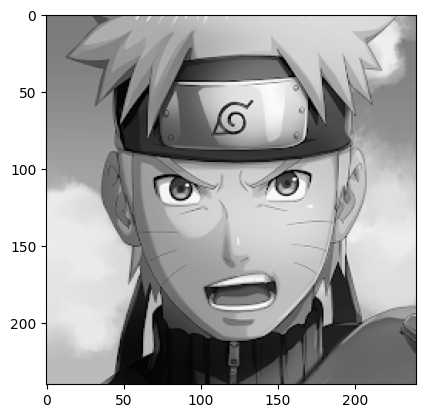

In [148]:
img = cv.imread('imgs/naruto.webp', cv.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

## Compress


### DCT

(array([[  0.,   2., 208., ...,   3.,   6.,  10.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   1., 239., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.]]),
 array([-554.44388234, -299.88699411,  -45.33010588,  209.22678236,
         463.78367059,  718.34055883,  972.89744706, 1227.4543353 ,
        1482.01122353, 1736.56811177, 1991.125     ]),
 <a list of 240 BarContainer objects>)

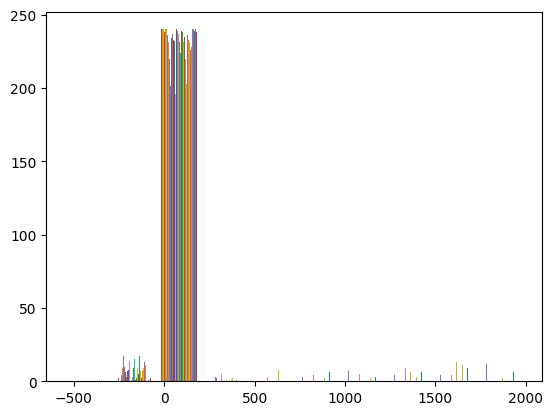

In [149]:
Y = DCT(img)
plt.hist(Y)

### Quantizando

(array([[  0.,   0., 209., ...,   6.,   4.,  12.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.]]),
 array([-50. , -32.6, -15.2,   2.2,  19.6,  37. ,  54.4,  71.8,  89.2,
        106.6, 124. ]),
 <a list of 240 BarContainer objects>)

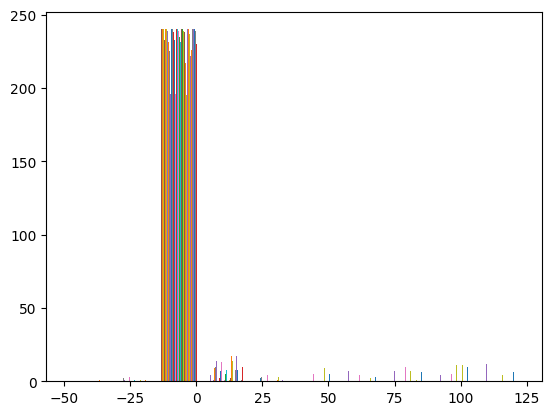

In [150]:
Y_quant = quant_DCT(Y)
plt.hist(Y_quant)

### Função de Predição + matriz de erros

In [151]:
U, V = Y_quant.shape

Error_predic1 = np.zeros(Y_quant.shape)
Error_predic2 = np.zeros(Y_quant.shape)
for u in range(U):
    for v in range(V):
        Error_predic1[u][v] = Y_quant[u][v] - predict_function_1(u, v, Y_quant)
        Error_predic2[u][v] = Y_quant[u][v] - predict_function_2(u, v, Y_quant)


Error_predic1[0][0] = Error_predic2[0][0] = Y_quant[0][0]

In [152]:
print(f'Y_quant have {np.unique(Y_quant).size} unique values')
print(f'Error_predict1 have {np.unique(Error_predic1).size} unique values')
print(f'Error predict2 have {np.unique(Error_predic2).size} unique values')

Y_quant have 164 unique values
Error_predict1 have 247 unique values
Error predict2 have 353 unique values


(array([[  0.,   0., 209., ...,   6.,   4.,  12.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.],
        [  0.,   0., 240., ...,   0.,   0.,   0.]]),
 array([-50. , -32.6, -15.2,   2.2,  19.6,  37. ,  54.4,  71.8,  89.2,
        106.6, 124. ]),
 <a list of 240 BarContainer objects>)

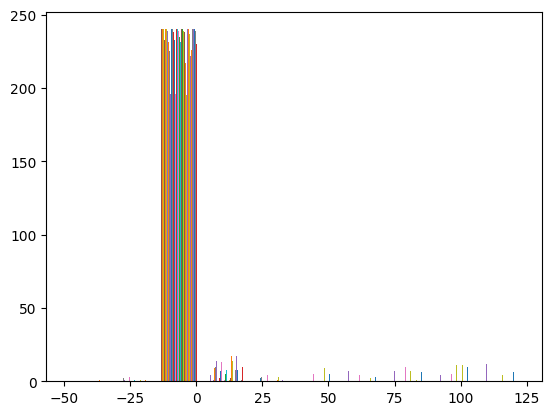

In [153]:
plt.hist(Y_quant)

### Huffman

## Unconpress

### Huffman

### Dequantizando

In [154]:
Y_dequant = dequant_DCT(Y_quant)

### Transformada inversa

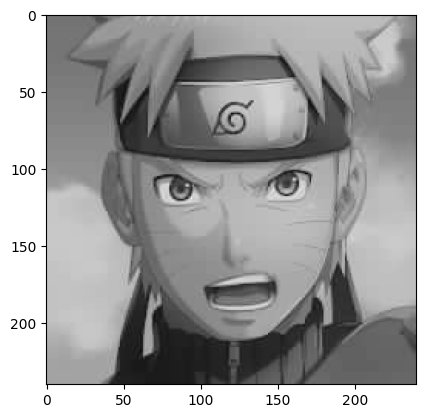

In [155]:
img_rec = iDCT(Y_dequant)
plt.imshow((img_rec), cmap='gray')


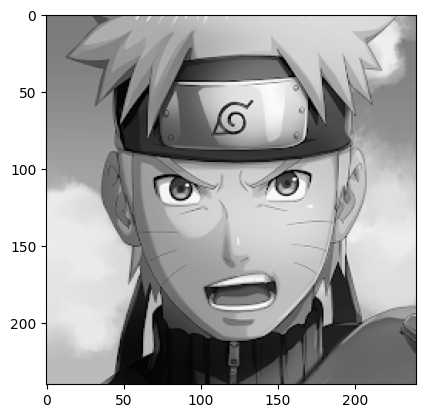

In [156]:
plt.imshow((img), cmap='gray')

# Análises


In [157]:
print(f'MSE: {((img - img_rec)**2).sum()/img.size}')
print(f'ME: {np.abs(img - img_rec).max()}')

MSE: 77.94558636333417
ME: 93.65404188382297


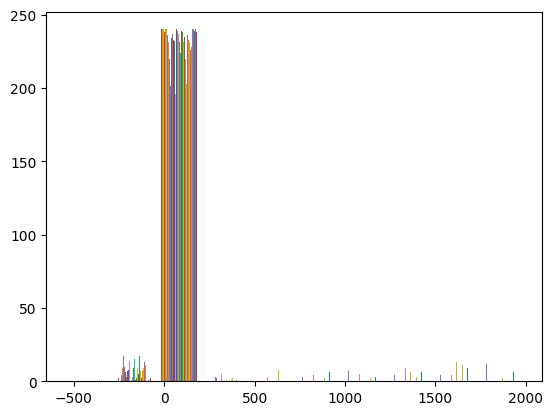

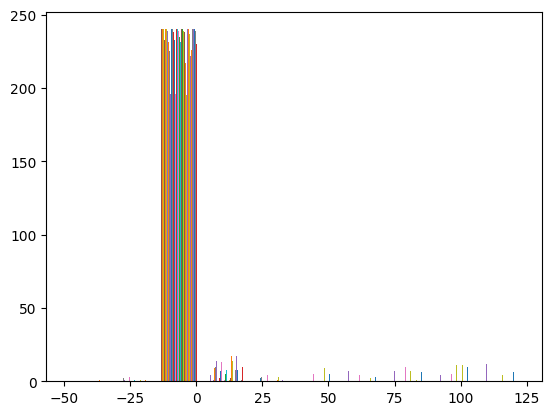

In [158]:
# histogramas de Y e Y_quant para, posteriormente, criar matriz de erros para huffman
# observe o eixo-x, i.e. os erros serão mais próximos
plt.hist(Y)
plt.show()
plt.hist(Y_quant)
plt.show()

In [159]:
(np.unique(Y).size, np.unique(Y_quant).size)

(51248, 164)